In [1]:
# Cell 1: Test on HAM10000 images
import sys
sys.path.append("..")

from medjepa.data.preprocessing import MedicalImagePreprocessor
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

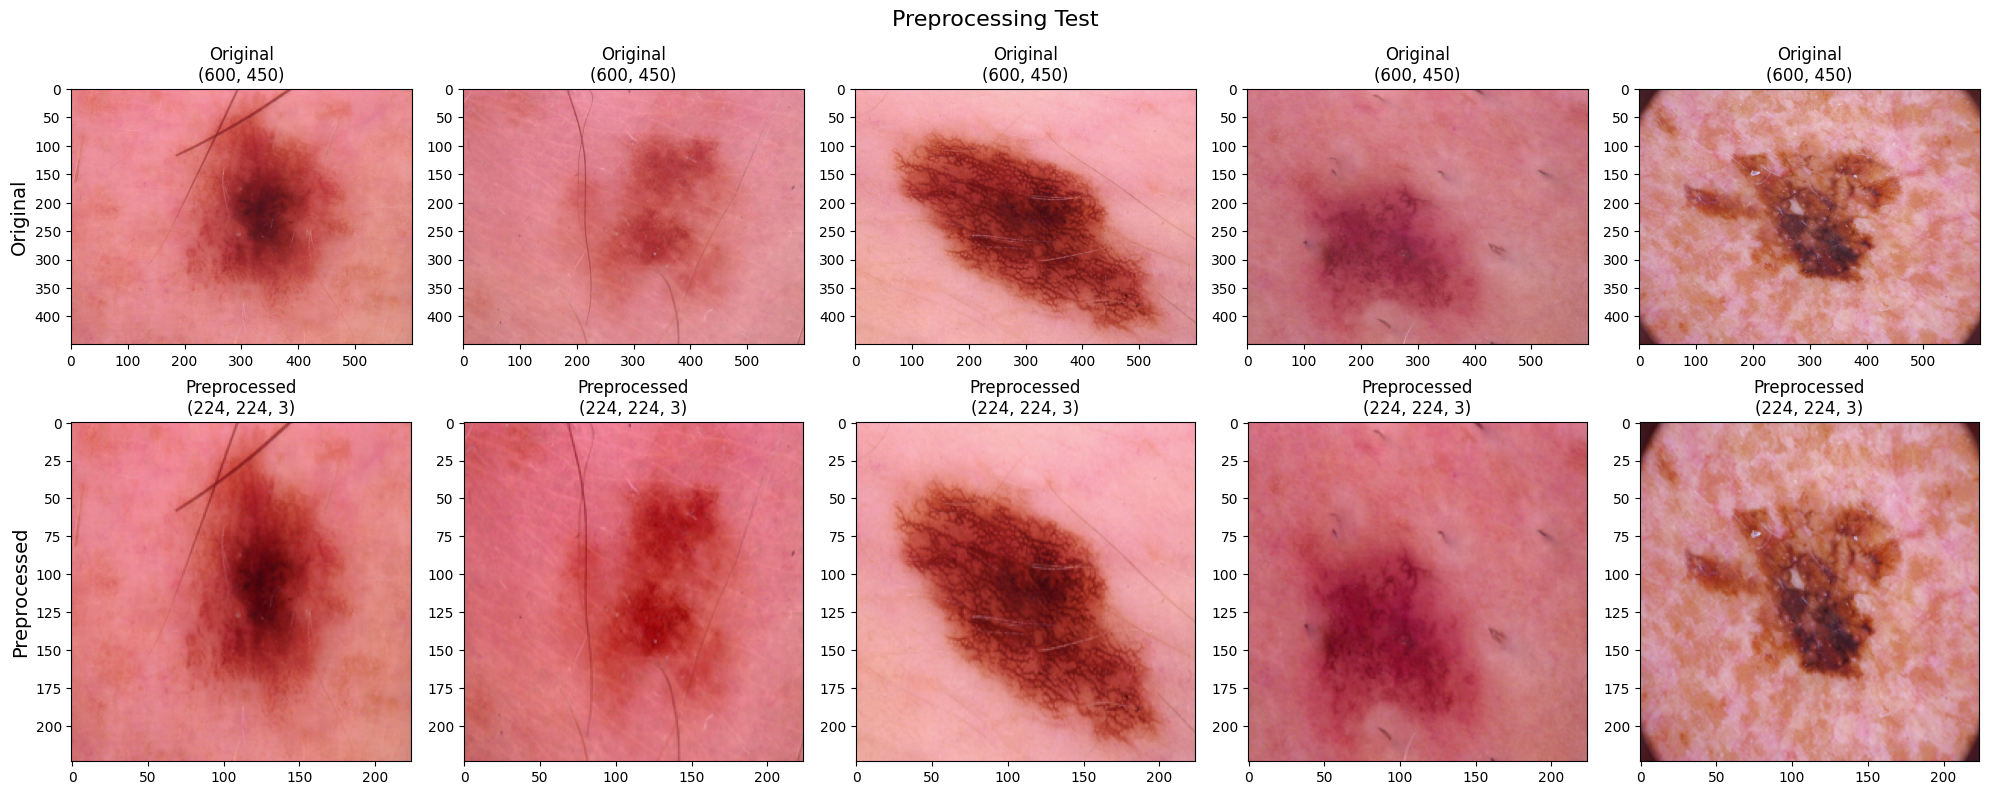

In [2]:
# Cell 2: Preprocess some images
preprocessor = MedicalImagePreprocessor(target_size=(224, 224))

# Find some HAM10000 images
image_dir = Path("../data/raw/ham10000")
images = list(image_dir.rglob("*.jpg"))[:5]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, img_path in enumerate(images):
    # Show original
    from PIL import Image
    orig = Image.open(img_path)
    axes[0][i].imshow(orig)
    axes[0][i].set_title(f"Original\n{orig.size}")

    # Show preprocessed
    processed = preprocessor.preprocess(str(img_path))
    axes[1][i].imshow(processed)
    axes[1][i].set_title(f"Preprocessed\n{processed.shape}")

axes[0][0].set_ylabel("Original", fontsize=14)
axes[1][0].set_ylabel("Preprocessed", fontsize=14)
plt.suptitle("Preprocessing Test", fontsize=16)
plt.tight_layout()
plt.show()

In [3]:
# Cell 3: Test the dataset class
from medjepa.data.datasets import MedicalImageDataset
from torch.utils.data import DataLoader

dataset = MedicalImageDataset(
    image_dir="../data/raw/ham10000",
    file_extension=".jpg",
    target_size=(224, 224),
)

print(f"Dataset size: {len(dataset)} images")

# Load one image
sample = dataset[0]
print(f"Image tensor shape: {sample.shape}")    # Should be (3, 224, 224)
print(f"Value range: {sample.min():.3f} to {sample.max():.3f}")  # Should be near 0-1

# Test DataLoader (loads images in batches)
loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)
batch = next(iter(loader))
print(f"Batch shape: {batch.shape}")  # Should be (16, 3, 224, 224)

Dataset size: 10015 images
Image tensor shape: torch.Size([3, 224, 224])
Value range: 0.008 to 0.965
Batch shape: torch.Size([16, 3, 224, 224])


In [ ]:
# Cell 4: Test NIfTI / 3D volume preprocessing (BraTS)
try:
    import nibabel as nib
    from pathlib import Path

    brats_dir = Path("../data/raw/brats")
    subjects = sorted([d for d in brats_dir.iterdir() if d.is_dir() and d.name.startswith("BraTS")])

    if subjects:
        sub = subjects[0]
        flair_path = sub / f"{sub.name}_flair.nii.gz"
        seg_path = sub / f"{sub.name}_seg.nii.gz"

        if flair_path.exists():
            vol = nib.load(str(flair_path)).get_fdata()
            print(f"BraTS volume shape: {vol.shape}")
            print(f"Value range: [{vol.min():.2f}, {vol.max():.2f}]")
            print(f"Dtype: {vol.dtype}")

            # Normalize to [0, 1]
            vol_norm = (vol - vol.min()) / (vol.max() - vol.min() + 1e-8)

            # Show multiple slices through the volume
            n_show = 8
            indices = np.linspace(int(vol.shape[2]*0.2), int(vol.shape[2]*0.8), n_show, dtype=int)
            fig, axes = plt.subplots(2, n_show, figsize=(20, 6))

            for i, si in enumerate(indices):
                # Raw slice
                axes[0][i].imshow(vol[:, :, si], cmap='gray')
                axes[0][i].set_title(f"Slice {si}", fontsize=8)
                axes[0][i].axis('off')

                # Preprocessed: resize to 224x224
                from PIL import Image as PILImage
                slc = vol_norm[:, :, si]
                pil_img = PILImage.fromarray((slc * 255).astype(np.uint8))
                pil_img = pil_img.resize((224, 224), PILImage.LANCZOS)
                axes[1][i].imshow(np.array(pil_img), cmap='gray')
                axes[1][i].set_title(f"224x224", fontsize=8)
                axes[1][i].axis('off')

            axes[0][0].set_ylabel("Raw", fontsize=11)
            axes[1][0].set_ylabel("Preprocessed", fontsize=11)
            plt.suptitle(f"NIfTI Preprocessing: {sub.name} FLAIR", fontsize=14)
            plt.tight_layout()
            plt.show()

            # Also show segmentation overlay
            if seg_path.exists():
                seg = nib.load(str(seg_path)).get_fdata()
                mid = vol.shape[2] // 2
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(vol[:, :, mid], cmap='gray')
                axes[0].set_title("FLAIR")
                axes[1].imshow(seg[:, :, mid], cmap='jet')
                axes[1].set_title("Segmentation Mask")
                axes[2].imshow(vol[:, :, mid], cmap='gray')
                axes[2].imshow(seg[:, :, mid], cmap='jet', alpha=0.4)
                axes[2].set_title("Overlay")
                for ax in axes:
                    ax.axis('off')
                plt.suptitle("BraTS Segmentation Mask Overlay", fontsize=14)
                plt.tight_layout()
                plt.show()
        else:
            print(f"FLAIR not found at {flair_path}")
    else:
        print("No BraTS subjects found.")
except ImportError:
    print("nibabel not installed. Run: pip install nibabel")